# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

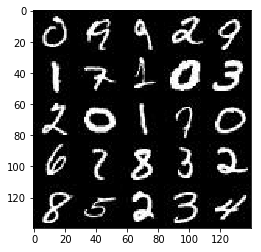

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

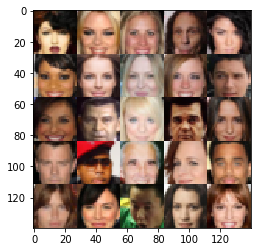

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        filters = 64
        # Input layer is 28x28x3
        x = tf.layers.conv2d(inputs = x, 
                     filters = filters, 
                     kernel_size = 5, 
                     strides = 1,
                     padding="same")
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        for i in range(3):
            x = tf.layers.conv2d(inputs = x, 
                                 filters = filters, 
                                 kernel_size = 5, 
                                 strides = 2,
                                 padding="same")
            #x = tf.layers.batch_normalization(x, training = True)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            filters = 2*filters
        #print(x.get_shape().as_list())
        flat = tf.contrib.layers.flatten(x)
        logits = tf.layers.dense(flat,1)
        #out = tf.sigmoid(logits)
        
        return logits

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    # Why on earth does the test check for the number of args?
    alpha = 0.2
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    init_dim =[-1,7,7,512]
    init_len = 7*7*512
    filters = 512
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z,init_len)
        x = tf.reshape(x, tf.cast(init_dim, tf.int32))
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        # so now we're at 7x7x512
        for i in range(2):
            filters = filters/2
            x = tf.layers.conv2d_transpose(inputs = x, 
                                           filters = int(filters), 
                                           kernel_size =5,
                                           strides = 2,
                                           padding = 'same')

            x = tf.layers.batch_normalization(x, training = is_train)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        
        x = tf.layers.conv2d_transpose(inputs = x, 
                                   filters = out_channel_dim, 
                                   kernel_size = 5,
                                   strides = 1,
                                   padding = 'same')
        # Output layer, 28x28x3 
        # rather than mess around with convolutions to get the size just right, let's just trim it
        #logits = tf.slice(x, [0,0,0,0],[-1,28,28,-1])
        logits = x
        out = 0.5*tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, batch_size, alpha=0.2, lmbda = 10):
    
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    input_fake = generator(input_z, out_channel_dim)
    d_real = discriminator(input_real, alpha=alpha)
    d_fake = discriminator(input_fake, reuse=True, alpha=alpha)
    
    alpha2 = tf.random_uniform(shape=[batch_size,1,1,1], minval=0.,maxval=1.)
    
    #TODO: does this work correctly with broadcasting?
    interpolates = alpha2*input_real + ((1-alpha2)*input_fake)
    disc_interpolates = discriminator(interpolates, reuse=True, alpha=alpha)
    gradients = tf.gradients([disc_interpolates], [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1,2,3]))
    gradient_penalty = tf.reduce_mean((slopes-1)**2)
 
    
    
    d_loss = -(tf.reduce_mean(d_real) - tf.reduce_mean(d_fake))
    d_loss += lmbda*gradient_penalty
    
    g_loss = -tf.reduce_mean(d_fake)

    return d_loss, g_loss


# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
# tests.test_model_loss(model_loss)

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    critic_iter= 5
    
    dummy, image_width, image_height, out_channel_dim =  data_shape
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, batch_size)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
                
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                for _ in range(critic_iter):
                    _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z,out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 1, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    import pickle
    with open('samples.pkl', 'wb') as f:
        pickle.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: -9.8874... Generator Loss: 2.9162
Epoch 1/2... Discriminator Loss: -10.6398... Generator Loss: 6.4879
Epoch 1/2... Discriminator Loss: -11.8738... Generator Loss: 6.8751
Epoch 1/2... Discriminator Loss: -3.8849... Generator Loss: -2.9516
Epoch 1/2... Discriminator Loss: -2.9121... Generator Loss: -4.8554
Epoch 1/2... Discriminator Loss: -0.9976... Generator Loss: -3.5800
Epoch 1/2... Discriminator Loss: -0.7259... Generator Loss: -5.6060
Epoch 1/2... Discriminator Loss: -0.8169... Generator Loss: -1.1124
Epoch 1/2... Discriminator Loss: -0.8024... Generator Loss: 4.6035
Epoch 1/2... Discriminator Loss: -1.3986... Generator Loss: 9.5947


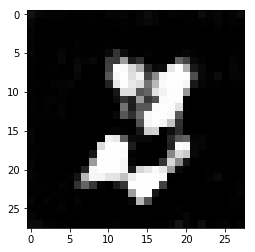

Epoch 1/2... Discriminator Loss: -1.1308... Generator Loss: 9.2322
Epoch 1/2... Discriminator Loss: -1.0256... Generator Loss: 2.7459
Epoch 1/2... Discriminator Loss: -1.4003... Generator Loss: 6.6364
Epoch 1/2... Discriminator Loss: -1.0635... Generator Loss: 1.5482
Epoch 1/2... Discriminator Loss: -0.5275... Generator Loss: 10.0139
Epoch 1/2... Discriminator Loss: -1.3996... Generator Loss: 2.6940
Epoch 1/2... Discriminator Loss: -1.3817... Generator Loss: 1.8123
Epoch 1/2... Discriminator Loss: -1.3577... Generator Loss: -1.7565
Epoch 1/2... Discriminator Loss: -1.5377... Generator Loss: 0.3296
Epoch 1/2... Discriminator Loss: -1.7193... Generator Loss: 1.6821


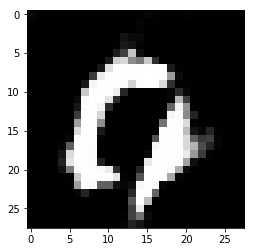

Epoch 1/2... Discriminator Loss: -1.3673... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: -1.7659... Generator Loss: 1.2713
Epoch 1/2... Discriminator Loss: -1.4804... Generator Loss: 2.5587
Epoch 1/2... Discriminator Loss: -1.8107... Generator Loss: 0.1658
Epoch 1/2... Discriminator Loss: -1.4445... Generator Loss: 1.2752
Epoch 1/2... Discriminator Loss: -1.6125... Generator Loss: 3.7476
Epoch 1/2... Discriminator Loss: -1.3634... Generator Loss: -0.5993
Epoch 1/2... Discriminator Loss: -1.3703... Generator Loss: 0.1573
Epoch 1/2... Discriminator Loss: -1.6787... Generator Loss: 2.3552
Epoch 1/2... Discriminator Loss: -1.3032... Generator Loss: -0.4385


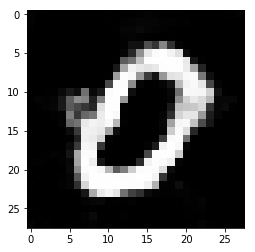

Epoch 1/2... Discriminator Loss: -1.5608... Generator Loss: -1.0480
Epoch 1/2... Discriminator Loss: -1.2524... Generator Loss: -3.8579
Epoch 1/2... Discriminator Loss: -1.0538... Generator Loss: -5.2518
Epoch 1/2... Discriminator Loss: -1.1242... Generator Loss: -8.5809
Epoch 1/2... Discriminator Loss: -1.5193... Generator Loss: -7.3667
Epoch 1/2... Discriminator Loss: -1.0671... Generator Loss: 0.3909
Epoch 1/2... Discriminator Loss: -0.9098... Generator Loss: -3.5532
Epoch 1/2... Discriminator Loss: -1.1977... Generator Loss: -6.0967
Epoch 1/2... Discriminator Loss: -1.0103... Generator Loss: 3.7875
Epoch 1/2... Discriminator Loss: -1.2047... Generator Loss: 1.9919


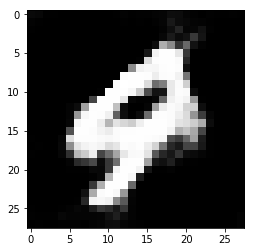

Epoch 1/2... Discriminator Loss: -1.0988... Generator Loss: 0.2567
Epoch 1/2... Discriminator Loss: -0.9084... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: -1.2298... Generator Loss: 1.3417
Epoch 1/2... Discriminator Loss: -0.8710... Generator Loss: -4.6101
Epoch 1/2... Discriminator Loss: -0.7992... Generator Loss: 6.2047
Epoch 1/2... Discriminator Loss: -0.9477... Generator Loss: -3.9254
Epoch 1/2... Discriminator Loss: -1.1592... Generator Loss: 2.0130
Epoch 1/2... Discriminator Loss: -1.2975... Generator Loss: -1.8410
Epoch 1/2... Discriminator Loss: -1.1041... Generator Loss: 3.0118
Epoch 1/2... Discriminator Loss: -1.1049... Generator Loss: 2.7261


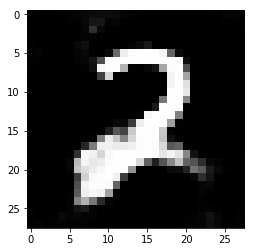

Epoch 1/2... Discriminator Loss: -1.2727... Generator Loss: 3.9526
Epoch 1/2... Discriminator Loss: -1.2456... Generator Loss: 3.4427
Epoch 1/2... Discriminator Loss: -0.9949... Generator Loss: -4.9165
Epoch 1/2... Discriminator Loss: -0.8148... Generator Loss: 5.2398
Epoch 1/2... Discriminator Loss: -1.1533... Generator Loss: 3.1561
Epoch 1/2... Discriminator Loss: -0.9967... Generator Loss: 5.7795
Epoch 1/2... Discriminator Loss: -1.2511... Generator Loss: 1.9883
Epoch 1/2... Discriminator Loss: -0.8225... Generator Loss: -2.0427
Epoch 1/2... Discriminator Loss: -0.9309... Generator Loss: 6.5050
Epoch 1/2... Discriminator Loss: -1.0757... Generator Loss: -1.6330


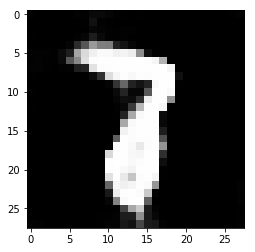

Epoch 1/2... Discriminator Loss: -0.9748... Generator Loss: -1.0250
Epoch 1/2... Discriminator Loss: -0.5913... Generator Loss: 2.4954
Epoch 1/2... Discriminator Loss: -1.1734... Generator Loss: 1.9268
Epoch 1/2... Discriminator Loss: -0.9409... Generator Loss: 2.8258
Epoch 1/2... Discriminator Loss: -0.8638... Generator Loss: 3.6217
Epoch 1/2... Discriminator Loss: -1.2116... Generator Loss: 2.7289
Epoch 1/2... Discriminator Loss: -1.0585... Generator Loss: 1.6712
Epoch 1/2... Discriminator Loss: -0.9708... Generator Loss: 2.8619
Epoch 1/2... Discriminator Loss: -1.0145... Generator Loss: 5.4356
Epoch 1/2... Discriminator Loss: -1.1807... Generator Loss: 6.0705


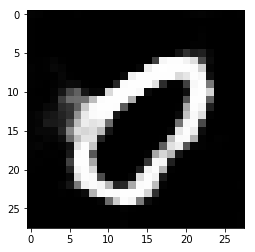

Epoch 1/2... Discriminator Loss: -0.9069... Generator Loss: 0.2948
Epoch 1/2... Discriminator Loss: -0.8593... Generator Loss: 5.7536
Epoch 1/2... Discriminator Loss: -1.3972... Generator Loss: -3.9255
Epoch 1/2... Discriminator Loss: -1.0554... Generator Loss: -1.9013
Epoch 1/2... Discriminator Loss: -1.2386... Generator Loss: 6.0572
Epoch 1/2... Discriminator Loss: -1.0199... Generator Loss: 7.5364
Epoch 1/2... Discriminator Loss: -1.2239... Generator Loss: -2.4347
Epoch 1/2... Discriminator Loss: -1.1834... Generator Loss: 0.2579
Epoch 1/2... Discriminator Loss: -0.8994... Generator Loss: 5.6403
Epoch 1/2... Discriminator Loss: -1.0635... Generator Loss: -0.0132


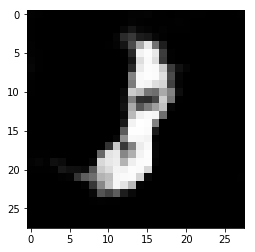

Epoch 1/2... Discriminator Loss: -1.1705... Generator Loss: -0.2171
Epoch 1/2... Discriminator Loss: -1.0859... Generator Loss: 5.4544
Epoch 1/2... Discriminator Loss: -1.2493... Generator Loss: 2.7734
Epoch 1/2... Discriminator Loss: -1.1826... Generator Loss: 2.0091
Epoch 1/2... Discriminator Loss: -1.1366... Generator Loss: 3.4147
Epoch 1/2... Discriminator Loss: -1.1151... Generator Loss: 2.8796
Epoch 1/2... Discriminator Loss: -1.2097... Generator Loss: 0.3561
Epoch 1/2... Discriminator Loss: -1.0334... Generator Loss: 5.6094
Epoch 1/2... Discriminator Loss: -1.4666... Generator Loss: 1.1785
Epoch 1/2... Discriminator Loss: -1.4803... Generator Loss: 6.5166


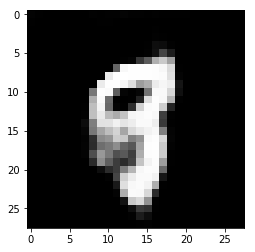

Epoch 1/2... Discriminator Loss: -1.4727... Generator Loss: 6.7353
Epoch 1/2... Discriminator Loss: -1.1424... Generator Loss: 2.7363
Epoch 1/2... Discriminator Loss: -0.7647... Generator Loss: 4.6729
Epoch 2/2... Discriminator Loss: -1.2428... Generator Loss: 2.2501
Epoch 2/2... Discriminator Loss: -1.0013... Generator Loss: 7.3012
Epoch 2/2... Discriminator Loss: -1.1818... Generator Loss: -1.2057
Epoch 2/2... Discriminator Loss: -1.3884... Generator Loss: 3.4070
Epoch 2/2... Discriminator Loss: -1.1965... Generator Loss: 1.5204
Epoch 2/2... Discriminator Loss: -1.0477... Generator Loss: 2.6509
Epoch 2/2... Discriminator Loss: -1.3142... Generator Loss: 1.1198


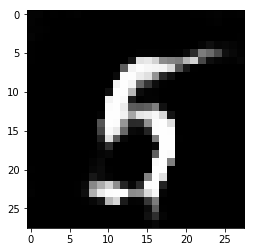

Epoch 2/2... Discriminator Loss: -1.1759... Generator Loss: 5.2921
Epoch 2/2... Discriminator Loss: -1.7422... Generator Loss: 6.9367
Epoch 2/2... Discriminator Loss: -0.9625... Generator Loss: 3.3427
Epoch 2/2... Discriminator Loss: -1.0504... Generator Loss: 3.4983
Epoch 2/2... Discriminator Loss: -1.1100... Generator Loss: 1.1550
Epoch 2/2... Discriminator Loss: -1.2964... Generator Loss: 3.4896
Epoch 2/2... Discriminator Loss: -1.5431... Generator Loss: 4.7085
Epoch 2/2... Discriminator Loss: -1.1376... Generator Loss: 2.0322
Epoch 2/2... Discriminator Loss: -1.2526... Generator Loss: 2.1685
Epoch 2/2... Discriminator Loss: -1.1514... Generator Loss: 1.6468


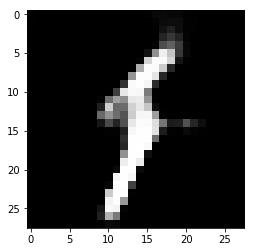

Epoch 2/2... Discriminator Loss: -1.4851... Generator Loss: 6.1395
Epoch 2/2... Discriminator Loss: -1.2342... Generator Loss: 4.7003
Epoch 2/2... Discriminator Loss: -1.4988... Generator Loss: 4.7114
Epoch 2/2... Discriminator Loss: -1.4453... Generator Loss: 3.6182
Epoch 2/2... Discriminator Loss: -1.3482... Generator Loss: 2.5634
Epoch 2/2... Discriminator Loss: -1.4529... Generator Loss: 7.5301
Epoch 2/2... Discriminator Loss: -1.4554... Generator Loss: 4.8746
Epoch 2/2... Discriminator Loss: -0.8847... Generator Loss: 4.3342
Epoch 2/2... Discriminator Loss: -1.1926... Generator Loss: 7.2658
Epoch 2/2... Discriminator Loss: -1.5539... Generator Loss: 5.5561


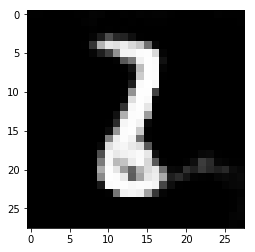

Epoch 2/2... Discriminator Loss: -1.6764... Generator Loss: 5.1733
Epoch 2/2... Discriminator Loss: -1.1841... Generator Loss: 3.6116
Epoch 2/2... Discriminator Loss: -1.1934... Generator Loss: 6.9693
Epoch 2/2... Discriminator Loss: -1.0153... Generator Loss: 1.8542
Epoch 2/2... Discriminator Loss: -1.2727... Generator Loss: 3.4229
Epoch 2/2... Discriminator Loss: -1.1927... Generator Loss: 5.2843
Epoch 2/2... Discriminator Loss: -1.0706... Generator Loss: 6.9214
Epoch 2/2... Discriminator Loss: -1.5141... Generator Loss: 7.2246
Epoch 2/2... Discriminator Loss: -1.7742... Generator Loss: 4.0102
Epoch 2/2... Discriminator Loss: -1.2852... Generator Loss: 4.8564


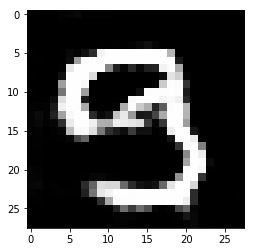

Epoch 2/2... Discriminator Loss: -1.4516... Generator Loss: 8.2496
Epoch 2/2... Discriminator Loss: -1.3328... Generator Loss: 3.6187
Epoch 2/2... Discriminator Loss: -1.3760... Generator Loss: 3.5221
Epoch 2/2... Discriminator Loss: -1.1016... Generator Loss: 4.5220
Epoch 2/2... Discriminator Loss: -1.1312... Generator Loss: 2.2860
Epoch 2/2... Discriminator Loss: -1.1033... Generator Loss: 5.3241
Epoch 2/2... Discriminator Loss: -1.7523... Generator Loss: 6.9761
Epoch 2/2... Discriminator Loss: -1.5722... Generator Loss: 6.6578
Epoch 2/2... Discriminator Loss: -1.3252... Generator Loss: 3.1839
Epoch 2/2... Discriminator Loss: -1.3200... Generator Loss: 7.0643


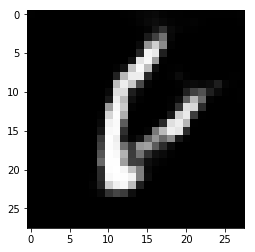

Epoch 2/2... Discriminator Loss: -1.2798... Generator Loss: 4.7046
Epoch 2/2... Discriminator Loss: -1.1393... Generator Loss: 4.7363
Epoch 2/2... Discriminator Loss: -1.1553... Generator Loss: 4.9530
Epoch 2/2... Discriminator Loss: -1.3050... Generator Loss: 6.4252
Epoch 2/2... Discriminator Loss: -1.5663... Generator Loss: 11.5176
Epoch 2/2... Discriminator Loss: -1.4913... Generator Loss: 4.0814
Epoch 2/2... Discriminator Loss: -1.4588... Generator Loss: 5.2568
Epoch 2/2... Discriminator Loss: -1.3440... Generator Loss: 8.5827
Epoch 2/2... Discriminator Loss: -1.4480... Generator Loss: 7.8632
Epoch 2/2... Discriminator Loss: -1.4935... Generator Loss: 4.0183


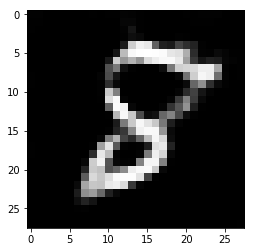

Epoch 2/2... Discriminator Loss: -1.1004... Generator Loss: 8.1393
Epoch 2/2... Discriminator Loss: -1.4847... Generator Loss: 6.7271
Epoch 2/2... Discriminator Loss: -1.3964... Generator Loss: 4.8068
Epoch 2/2... Discriminator Loss: -1.2942... Generator Loss: 7.1593
Epoch 2/2... Discriminator Loss: -1.1087... Generator Loss: 7.9435
Epoch 2/2... Discriminator Loss: -1.2286... Generator Loss: 8.0504
Epoch 2/2... Discriminator Loss: -1.2249... Generator Loss: 3.9923
Epoch 2/2... Discriminator Loss: -1.4086... Generator Loss: 5.8871
Epoch 2/2... Discriminator Loss: -1.3966... Generator Loss: 5.5525
Epoch 2/2... Discriminator Loss: -1.4633... Generator Loss: 5.2031


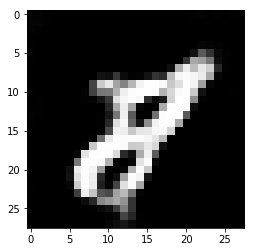

Epoch 2/2... Discriminator Loss: -1.3717... Generator Loss: 6.9818
Epoch 2/2... Discriminator Loss: -1.3471... Generator Loss: 7.3233
Epoch 2/2... Discriminator Loss: -1.4777... Generator Loss: 7.2640
Epoch 2/2... Discriminator Loss: -1.2968... Generator Loss: 4.0692
Epoch 2/2... Discriminator Loss: -1.4306... Generator Loss: 9.2605
Epoch 2/2... Discriminator Loss: -1.3472... Generator Loss: 3.6057
Epoch 2/2... Discriminator Loss: -1.3594... Generator Loss: 5.6092
Epoch 2/2... Discriminator Loss: -1.0964... Generator Loss: 4.2703
Epoch 2/2... Discriminator Loss: -1.2486... Generator Loss: 3.1897
Epoch 2/2... Discriminator Loss: -1.0412... Generator Loss: 5.0026


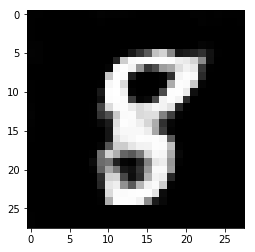

Epoch 2/2... Discriminator Loss: -1.2192... Generator Loss: 7.1502
Epoch 2/2... Discriminator Loss: -1.3035... Generator Loss: 5.1892
Epoch 2/2... Discriminator Loss: -1.0073... Generator Loss: 2.1546
Epoch 2/2... Discriminator Loss: -1.1806... Generator Loss: 5.9312
Epoch 2/2... Discriminator Loss: -1.2239... Generator Loss: 4.3006
Epoch 2/2... Discriminator Loss: -1.3315... Generator Loss: 5.7823
Epoch 2/2... Discriminator Loss: -1.7386... Generator Loss: 10.4888
Epoch 2/2... Discriminator Loss: -1.0896... Generator Loss: 5.7011
Epoch 2/2... Discriminator Loss: -1.5954... Generator Loss: 7.0202
Epoch 2/2... Discriminator Loss: -1.1642... Generator Loss: 4.6552


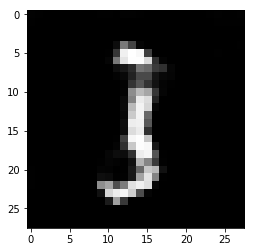

Epoch 2/2... Discriminator Loss: -1.4217... Generator Loss: 6.0588
Epoch 2/2... Discriminator Loss: -1.3765... Generator Loss: 8.8851
Epoch 2/2... Discriminator Loss: -1.3586... Generator Loss: 8.5487
Epoch 2/2... Discriminator Loss: -1.2745... Generator Loss: 8.7060
Epoch 2/2... Discriminator Loss: -1.2300... Generator Loss: 6.5712
Epoch 2/2... Discriminator Loss: -1.8278... Generator Loss: 7.3970
Epoch 2/2... Discriminator Loss: -1.5288... Generator Loss: 6.5376


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: -18.1693... Generator Loss: 21.6159
Epoch 1/10... Discriminator Loss: -14.2095... Generator Loss: 18.3886
Epoch 1/10... Discriminator Loss: -6.9328... Generator Loss: 10.0991
Epoch 1/10... Discriminator Loss: -4.6267... Generator Loss: 9.3084
Epoch 1/10... Discriminator Loss: -4.5121... Generator Loss: 4.2635
Epoch 1/10... Discriminator Loss: -3.0371... Generator Loss: 2.1196
Epoch 1/10... Discriminator Loss: -3.2096... Generator Loss: 4.6196
Epoch 1/10... Discriminator Loss: -2.1043... Generator Loss: 5.1132
Epoch 1/10... Discriminator Loss: -2.8194... Generator Loss: -0.4722
Epoch 1/10... Discriminator Loss: -2.2991... Generator Loss: 3.2815
Epoch 1/10... Discriminator Loss: -2.2433... Generator Loss: 3.0975
Epoch 1/10... Discriminator Loss: -2.6892... Generator Loss: 5.2889
Epoch 1/10... Discriminator Loss: -1.9340... Generator Loss: -0.5074
Epoch 1/10... Discriminator Loss: -1.9534... Generator Loss: 3.4931
Epoch 1/10... Discriminator Loss: -1.8963

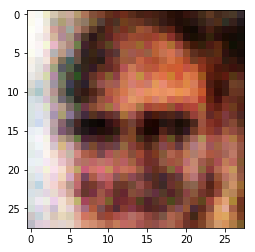

Epoch 1/10... Discriminator Loss: -0.8589... Generator Loss: -18.1107
Epoch 1/10... Discriminator Loss: -1.7191... Generator Loss: -11.2228
Epoch 1/10... Discriminator Loss: -1.4523... Generator Loss: -19.2341
Epoch 1/10... Discriminator Loss: -1.0833... Generator Loss: -23.0966
Epoch 1/10... Discriminator Loss: -1.3326... Generator Loss: -30.2328
Epoch 1/10... Discriminator Loss: -1.5082... Generator Loss: -28.0631
Epoch 1/10... Discriminator Loss: -1.0003... Generator Loss: -25.8053
Epoch 1/10... Discriminator Loss: -1.1591... Generator Loss: -21.4842
Epoch 1/10... Discriminator Loss: -0.3173... Generator Loss: -18.1254
Epoch 1/10... Discriminator Loss: -1.0672... Generator Loss: -17.0975
Epoch 1/10... Discriminator Loss: -0.3799... Generator Loss: -24.4929
Epoch 1/10... Discriminator Loss: -0.9276... Generator Loss: -31.5530
Epoch 1/10... Discriminator Loss: -0.9065... Generator Loss: -27.6306
Epoch 1/10... Discriminator Loss: -1.3158... Generator Loss: -8.7703
Epoch 1/10... Discrim

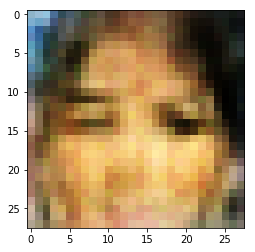

Epoch 1/10... Discriminator Loss: -1.2299... Generator Loss: -14.8747
Epoch 1/10... Discriminator Loss: -0.7205... Generator Loss: -9.0442
Epoch 1/10... Discriminator Loss: -0.8531... Generator Loss: 10.0045
Epoch 1/10... Discriminator Loss: -0.7637... Generator Loss: -11.8959
Epoch 1/10... Discriminator Loss: -0.7728... Generator Loss: -20.8228
Epoch 1/10... Discriminator Loss: -0.9222... Generator Loss: -15.3153
Epoch 1/10... Discriminator Loss: -0.6922... Generator Loss: -18.5484
Epoch 1/10... Discriminator Loss: -0.5295... Generator Loss: -22.6392
Epoch 1/10... Discriminator Loss: -0.9911... Generator Loss: -12.7607
Epoch 1/10... Discriminator Loss: -0.5710... Generator Loss: -23.0639
Epoch 1/10... Discriminator Loss: -0.6872... Generator Loss: -37.2074
Epoch 1/10... Discriminator Loss: -0.2999... Generator Loss: -26.2344
Epoch 1/10... Discriminator Loss: -0.8872... Generator Loss: -15.0883
Epoch 1/10... Discriminator Loss: -0.8513... Generator Loss: -8.6529
Epoch 1/10... Discrimin

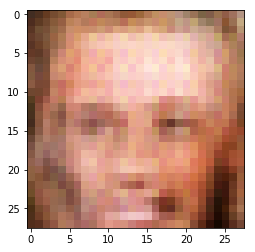

Epoch 1/10... Discriminator Loss: -0.8911... Generator Loss: -6.7919
Epoch 1/10... Discriminator Loss: -0.5177... Generator Loss: -30.1239
Epoch 1/10... Discriminator Loss: -0.9150... Generator Loss: -11.2259
Epoch 1/10... Discriminator Loss: -0.6029... Generator Loss: 0.3092
Epoch 1/10... Discriminator Loss: -0.7021... Generator Loss: -9.0569
Epoch 1/10... Discriminator Loss: -0.2091... Generator Loss: -29.9463
Epoch 1/10... Discriminator Loss: -0.6988... Generator Loss: -5.9517
Epoch 1/10... Discriminator Loss: -0.5268... Generator Loss: 4.3302
Epoch 2/10... Discriminator Loss: -1.0198... Generator Loss: 0.5641
Epoch 2/10... Discriminator Loss: -1.1109... Generator Loss: -11.7250
Epoch 2/10... Discriminator Loss: -0.6406... Generator Loss: -13.2964
Epoch 2/10... Discriminator Loss: -0.6070... Generator Loss: -11.0619
Epoch 2/10... Discriminator Loss: -0.9100... Generator Loss: -1.6005
Epoch 2/10... Discriminator Loss: -0.7009... Generator Loss: -18.7547
Epoch 2/10... Discriminator Lo

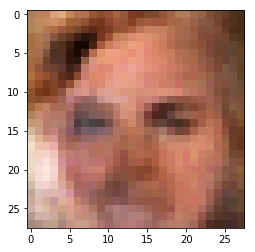

Epoch 2/10... Discriminator Loss: -0.4944... Generator Loss: 7.6953
Epoch 2/10... Discriminator Loss: -1.0113... Generator Loss: -3.1123
Epoch 2/10... Discriminator Loss: -0.6626... Generator Loss: -3.5033
Epoch 2/10... Discriminator Loss: -0.3805... Generator Loss: -4.2581
Epoch 2/10... Discriminator Loss: -0.6715... Generator Loss: -12.4188
Epoch 2/10... Discriminator Loss: -0.1322... Generator Loss: -0.1231
Epoch 2/10... Discriminator Loss: -0.5648... Generator Loss: 4.3247
Epoch 2/10... Discriminator Loss: -0.9499... Generator Loss: 0.8029
Epoch 2/10... Discriminator Loss: -0.7609... Generator Loss: 7.6892
Epoch 2/10... Discriminator Loss: -1.4569... Generator Loss: 0.5377
Epoch 2/10... Discriminator Loss: -0.9787... Generator Loss: -11.2389
Epoch 2/10... Discriminator Loss: -0.9905... Generator Loss: 3.5498
Epoch 2/10... Discriminator Loss: -0.5940... Generator Loss: -9.8735
Epoch 2/10... Discriminator Loss: -1.3923... Generator Loss: -0.7405
Epoch 2/10... Discriminator Loss: -1.2

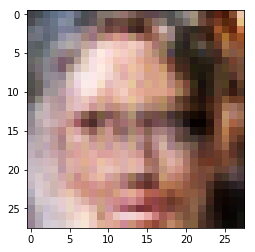

Epoch 2/10... Discriminator Loss: -0.5194... Generator Loss: 9.0581
Epoch 2/10... Discriminator Loss: -0.2967... Generator Loss: -2.4410
Epoch 2/10... Discriminator Loss: -0.2835... Generator Loss: -19.2421
Epoch 2/10... Discriminator Loss: -0.4937... Generator Loss: 9.5655
Epoch 2/10... Discriminator Loss: -0.9550... Generator Loss: -6.7367
Epoch 2/10... Discriminator Loss: -0.5994... Generator Loss: 4.7357
Epoch 2/10... Discriminator Loss: -0.4285... Generator Loss: 2.4055
Epoch 2/10... Discriminator Loss: -0.6659... Generator Loss: -2.7233
Epoch 2/10... Discriminator Loss: -0.7559... Generator Loss: 3.2626
Epoch 2/10... Discriminator Loss: -0.5518... Generator Loss: -11.6304
Epoch 2/10... Discriminator Loss: -0.7470... Generator Loss: -18.3529
Epoch 2/10... Discriminator Loss: -0.5591... Generator Loss: 8.5478
Epoch 2/10... Discriminator Loss: -0.6557... Generator Loss: -15.6076
Epoch 2/10... Discriminator Loss: -0.8115... Generator Loss: 0.3904
Epoch 2/10... Discriminator Loss: -0.

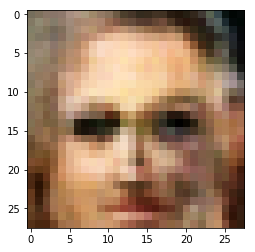

Epoch 2/10... Discriminator Loss: -1.0869... Generator Loss: 16.4145
Epoch 2/10... Discriminator Loss: -0.7018... Generator Loss: -8.3044
Epoch 2/10... Discriminator Loss: -0.7406... Generator Loss: 3.7611
Epoch 2/10... Discriminator Loss: -0.5019... Generator Loss: -7.6096
Epoch 2/10... Discriminator Loss: -0.9194... Generator Loss: -1.4689
Epoch 2/10... Discriminator Loss: -0.7925... Generator Loss: -8.9358
Epoch 2/10... Discriminator Loss: -0.8846... Generator Loss: 4.3335
Epoch 2/10... Discriminator Loss: -1.1675... Generator Loss: 5.8218
Epoch 2/10... Discriminator Loss: -0.7880... Generator Loss: -3.9126
Epoch 2/10... Discriminator Loss: -0.8443... Generator Loss: 12.6912
Epoch 2/10... Discriminator Loss: -0.4430... Generator Loss: 4.6211
Epoch 2/10... Discriminator Loss: -0.5643... Generator Loss: -9.4487
Epoch 2/10... Discriminator Loss: -0.7305... Generator Loss: -6.8762
Epoch 2/10... Discriminator Loss: -0.1028... Generator Loss: -6.4091
Epoch 2/10... Discriminator Loss: -0.9

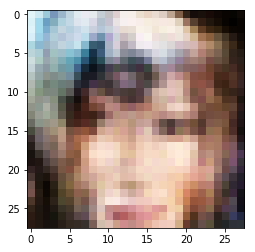

Epoch 3/10... Discriminator Loss: -0.8650... Generator Loss: -6.6125
Epoch 3/10... Discriminator Loss: -1.1763... Generator Loss: 0.9121
Epoch 3/10... Discriminator Loss: -1.1342... Generator Loss: 5.0024
Epoch 3/10... Discriminator Loss: -0.4928... Generator Loss: 2.1917
Epoch 3/10... Discriminator Loss: -1.0226... Generator Loss: 6.4179
Epoch 3/10... Discriminator Loss: -0.6766... Generator Loss: 2.9176
Epoch 3/10... Discriminator Loss: -0.4612... Generator Loss: -0.0538
Epoch 3/10... Discriminator Loss: -0.8439... Generator Loss: 5.0079
Epoch 3/10... Discriminator Loss: -0.6165... Generator Loss: -4.6336
Epoch 3/10... Discriminator Loss: -0.6703... Generator Loss: 4.9979
Epoch 3/10... Discriminator Loss: -0.5421... Generator Loss: 1.1476
Epoch 3/10... Discriminator Loss: -0.8763... Generator Loss: -10.1446
Epoch 3/10... Discriminator Loss: -0.7863... Generator Loss: 5.3752
Epoch 3/10... Discriminator Loss: -0.5739... Generator Loss: -16.4150
Epoch 3/10... Discriminator Loss: -1.0717

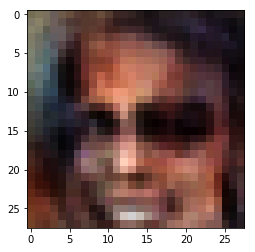

Epoch 3/10... Discriminator Loss: -1.0624... Generator Loss: -6.7287
Epoch 3/10... Discriminator Loss: -0.3388... Generator Loss: -13.6973
Epoch 3/10... Discriminator Loss: -0.3440... Generator Loss: -1.5837
Epoch 3/10... Discriminator Loss: -0.5427... Generator Loss: -4.3021
Epoch 3/10... Discriminator Loss: -1.0873... Generator Loss: -0.4028
Epoch 3/10... Discriminator Loss: -0.6693... Generator Loss: 0.1482
Epoch 3/10... Discriminator Loss: -1.1961... Generator Loss: -6.2076
Epoch 3/10... Discriminator Loss: -0.6662... Generator Loss: -9.7508
Epoch 3/10... Discriminator Loss: -0.9997... Generator Loss: -4.9494
Epoch 3/10... Discriminator Loss: -0.9288... Generator Loss: -4.2837
Epoch 3/10... Discriminator Loss: -1.2835... Generator Loss: -5.1961
Epoch 3/10... Discriminator Loss: -0.4740... Generator Loss: -2.2516
Epoch 3/10... Discriminator Loss: -0.7215... Generator Loss: -8.5883
Epoch 3/10... Discriminator Loss: -0.7919... Generator Loss: -6.1656
Epoch 3/10... Discriminator Loss: 

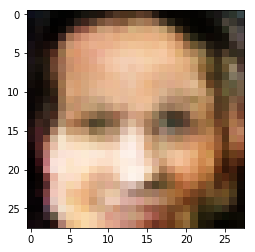

Epoch 3/10... Discriminator Loss: -0.6045... Generator Loss: -16.5503
Epoch 3/10... Discriminator Loss: -0.8734... Generator Loss: -6.5388
Epoch 3/10... Discriminator Loss: -0.7111... Generator Loss: 8.0903
Epoch 3/10... Discriminator Loss: -0.4204... Generator Loss: -7.9989
Epoch 3/10... Discriminator Loss: -0.5204... Generator Loss: -7.3454
Epoch 3/10... Discriminator Loss: -0.5542... Generator Loss: -10.3380
Epoch 3/10... Discriminator Loss: -0.4597... Generator Loss: 11.8915
Epoch 3/10... Discriminator Loss: -0.7005... Generator Loss: -14.2583
Epoch 3/10... Discriminator Loss: -0.9182... Generator Loss: -5.0689
Epoch 3/10... Discriminator Loss: -0.5984... Generator Loss: -5.5906
Epoch 3/10... Discriminator Loss: -0.7804... Generator Loss: -11.2248
Epoch 3/10... Discriminator Loss: -0.7529... Generator Loss: -5.7356
Epoch 3/10... Discriminator Loss: -1.0554... Generator Loss: -19.6990
Epoch 3/10... Discriminator Loss: -0.5937... Generator Loss: -0.3812
Epoch 3/10... Discriminator Lo

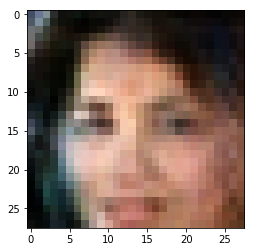

Epoch 4/10... Discriminator Loss: -0.5311... Generator Loss: 0.7769
Epoch 4/10... Discriminator Loss: -0.4103... Generator Loss: 2.6228
Epoch 4/10... Discriminator Loss: -1.0317... Generator Loss: 2.9440
Epoch 4/10... Discriminator Loss: -0.8575... Generator Loss: -3.6853
Epoch 4/10... Discriminator Loss: -0.8496... Generator Loss: -8.5667
Epoch 4/10... Discriminator Loss: -0.5700... Generator Loss: -0.7231
Epoch 4/10... Discriminator Loss: -0.6368... Generator Loss: -1.0464
Epoch 4/10... Discriminator Loss: -0.5945... Generator Loss: -5.5845
Epoch 4/10... Discriminator Loss: -0.5852... Generator Loss: -10.9877
Epoch 4/10... Discriminator Loss: -0.4704... Generator Loss: -3.8694
Epoch 4/10... Discriminator Loss: -0.6215... Generator Loss: 0.9061
Epoch 4/10... Discriminator Loss: -0.5696... Generator Loss: 1.9280
Epoch 4/10... Discriminator Loss: -0.6812... Generator Loss: -12.1832
Epoch 4/10... Discriminator Loss: -0.5432... Generator Loss: 3.7854
Epoch 4/10... Discriminator Loss: -1.2

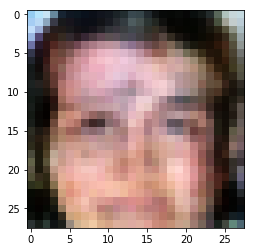

Epoch 4/10... Discriminator Loss: -0.4256... Generator Loss: -7.8328
Epoch 4/10... Discriminator Loss: -0.4849... Generator Loss: 9.0088
Epoch 4/10... Discriminator Loss: -0.7002... Generator Loss: -4.4392
Epoch 4/10... Discriminator Loss: -0.7143... Generator Loss: -1.5445
Epoch 4/10... Discriminator Loss: -0.6306... Generator Loss: -3.2095
Epoch 4/10... Discriminator Loss: -0.5213... Generator Loss: -8.3132
Epoch 4/10... Discriminator Loss: -0.6460... Generator Loss: 9.0584
Epoch 4/10... Discriminator Loss: -0.7182... Generator Loss: 3.9397
Epoch 4/10... Discriminator Loss: -0.8595... Generator Loss: -9.8864
Epoch 4/10... Discriminator Loss: -0.5715... Generator Loss: -7.0680
Epoch 4/10... Discriminator Loss: -0.7337... Generator Loss: -4.3791
Epoch 4/10... Discriminator Loss: -0.6471... Generator Loss: -3.0691
Epoch 4/10... Discriminator Loss: -0.5409... Generator Loss: -7.5144
Epoch 4/10... Discriminator Loss: -0.9157... Generator Loss: -4.0881
Epoch 4/10... Discriminator Loss: -0.

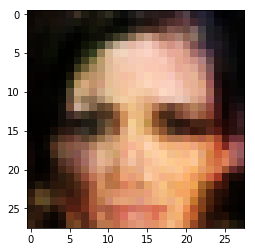

Epoch 4/10... Discriminator Loss: -0.8217... Generator Loss: -7.7965
Epoch 4/10... Discriminator Loss: -0.8671... Generator Loss: -3.6465
Epoch 4/10... Discriminator Loss: -1.1901... Generator Loss: -6.4779
Epoch 4/10... Discriminator Loss: -0.9677... Generator Loss: -10.4154
Epoch 4/10... Discriminator Loss: -0.6255... Generator Loss: 0.5428
Epoch 4/10... Discriminator Loss: -0.4398... Generator Loss: -11.0650
Epoch 4/10... Discriminator Loss: -0.6832... Generator Loss: -4.5158
Epoch 4/10... Discriminator Loss: -0.5175... Generator Loss: -10.5292
Epoch 4/10... Discriminator Loss: -1.0498... Generator Loss: -3.9094
Epoch 4/10... Discriminator Loss: -1.2578... Generator Loss: -2.7892
Epoch 4/10... Discriminator Loss: -0.4408... Generator Loss: -0.0709
Epoch 4/10... Discriminator Loss: -0.5399... Generator Loss: -4.8158
Epoch 4/10... Discriminator Loss: -0.5089... Generator Loss: -11.9794
Epoch 4/10... Discriminator Loss: -0.5067... Generator Loss: -3.5047
Epoch 4/10... Discriminator Los

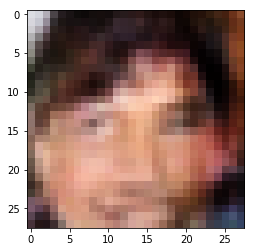

Epoch 5/10... Discriminator Loss: -0.7572... Generator Loss: -7.6017
Epoch 5/10... Discriminator Loss: -0.7770... Generator Loss: -1.1504
Epoch 5/10... Discriminator Loss: -1.1703... Generator Loss: 5.5253
Epoch 5/10... Discriminator Loss: -0.5993... Generator Loss: -1.2574
Epoch 5/10... Discriminator Loss: -0.5585... Generator Loss: 5.0775
Epoch 5/10... Discriminator Loss: -0.4972... Generator Loss: -2.9043
Epoch 5/10... Discriminator Loss: -0.9893... Generator Loss: -1.8326
Epoch 5/10... Discriminator Loss: -0.4885... Generator Loss: -14.3544
Epoch 5/10... Discriminator Loss: -1.0017... Generator Loss: -0.9543
Epoch 5/10... Discriminator Loss: -0.8055... Generator Loss: -8.4713
Epoch 5/10... Discriminator Loss: -0.9652... Generator Loss: 5.1873
Epoch 5/10... Discriminator Loss: -0.7949... Generator Loss: -7.1585
Epoch 5/10... Discriminator Loss: -0.8822... Generator Loss: -5.4968
Epoch 5/10... Discriminator Loss: -1.1881... Generator Loss: 0.9502
Epoch 5/10... Discriminator Loss: -0.

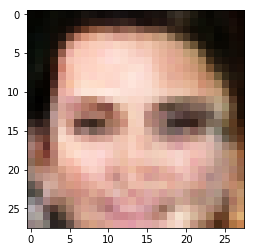

Epoch 5/10... Discriminator Loss: -0.8552... Generator Loss: -0.0565
Epoch 5/10... Discriminator Loss: -0.8866... Generator Loss: -15.7663
Epoch 5/10... Discriminator Loss: -0.6013... Generator Loss: 0.1161
Epoch 5/10... Discriminator Loss: -0.3271... Generator Loss: 12.2695
Epoch 5/10... Discriminator Loss: -0.4359... Generator Loss: 4.4009
Epoch 5/10... Discriminator Loss: -0.8937... Generator Loss: -3.9563
Epoch 5/10... Discriminator Loss: -0.4844... Generator Loss: -8.1025
Epoch 5/10... Discriminator Loss: -1.0059... Generator Loss: 14.2597
Epoch 5/10... Discriminator Loss: -0.4895... Generator Loss: -10.6776
Epoch 5/10... Discriminator Loss: -0.7100... Generator Loss: -3.7967
Epoch 5/10... Discriminator Loss: -0.8896... Generator Loss: -0.0175
Epoch 5/10... Discriminator Loss: -0.8471... Generator Loss: -4.8767
Epoch 5/10... Discriminator Loss: -0.9106... Generator Loss: 0.5726
Epoch 5/10... Discriminator Loss: -0.8243... Generator Loss: -0.5549
Epoch 5/10... Discriminator Loss: -

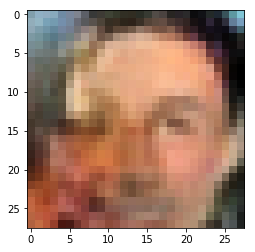

Epoch 5/10... Discriminator Loss: -0.8606... Generator Loss: -8.0049
Epoch 5/10... Discriminator Loss: -0.2636... Generator Loss: 2.2125
Epoch 5/10... Discriminator Loss: -0.6789... Generator Loss: -8.4512
Epoch 5/10... Discriminator Loss: -1.1364... Generator Loss: -12.4992
Epoch 5/10... Discriminator Loss: -0.4295... Generator Loss: -10.9902
Epoch 5/10... Discriminator Loss: -0.4991... Generator Loss: 0.8383
Epoch 5/10... Discriminator Loss: -0.8334... Generator Loss: -9.6888
Epoch 5/10... Discriminator Loss: -0.8232... Generator Loss: 9.9298
Epoch 5/10... Discriminator Loss: -0.5851... Generator Loss: 9.6658
Epoch 5/10... Discriminator Loss: -0.9581... Generator Loss: -19.8288
Epoch 5/10... Discriminator Loss: -0.8194... Generator Loss: 13.0569
Epoch 5/10... Discriminator Loss: -0.6740... Generator Loss: -2.2674
Epoch 5/10... Discriminator Loss: -0.5948... Generator Loss: -11.7434
Epoch 5/10... Discriminator Loss: -0.5595... Generator Loss: -3.5319
Epoch 5/10... Discriminator Loss: 

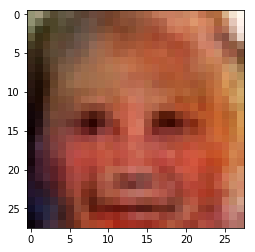

Epoch 6/10... Discriminator Loss: -0.5962... Generator Loss: -3.3291
Epoch 6/10... Discriminator Loss: -0.4513... Generator Loss: -4.1579
Epoch 6/10... Discriminator Loss: -0.6834... Generator Loss: -2.9835
Epoch 6/10... Discriminator Loss: -0.6071... Generator Loss: 2.2150
Epoch 6/10... Discriminator Loss: -0.8240... Generator Loss: -8.4740
Epoch 6/10... Discriminator Loss: -0.4270... Generator Loss: -5.1624
Epoch 6/10... Discriminator Loss: -0.5872... Generator Loss: 5.9138
Epoch 6/10... Discriminator Loss: -0.7337... Generator Loss: -7.0162
Epoch 6/10... Discriminator Loss: -0.4481... Generator Loss: 2.2150
Epoch 6/10... Discriminator Loss: -0.6441... Generator Loss: 6.6039
Epoch 6/10... Discriminator Loss: -0.7286... Generator Loss: -6.3565
Epoch 6/10... Discriminator Loss: -0.7607... Generator Loss: -1.8052
Epoch 6/10... Discriminator Loss: -0.9380... Generator Loss: -0.2704
Epoch 6/10... Discriminator Loss: -1.0610... Generator Loss: -5.1424
Epoch 6/10... Discriminator Loss: -0.7

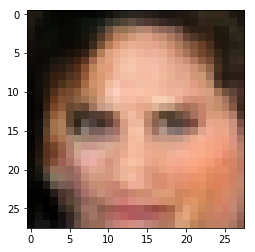

Epoch 6/10... Discriminator Loss: -0.3926... Generator Loss: 10.0627
Epoch 6/10... Discriminator Loss: -0.6442... Generator Loss: 10.6986
Epoch 6/10... Discriminator Loss: -0.5814... Generator Loss: -13.8610
Epoch 6/10... Discriminator Loss: -0.8366... Generator Loss: -5.1967
Epoch 6/10... Discriminator Loss: -0.4814... Generator Loss: -0.0295
Epoch 6/10... Discriminator Loss: -0.4999... Generator Loss: -10.5055
Epoch 6/10... Discriminator Loss: -0.6708... Generator Loss: -6.7715
Epoch 6/10... Discriminator Loss: -0.9259... Generator Loss: -1.5743
Epoch 6/10... Discriminator Loss: -0.7099... Generator Loss: -9.0180
Epoch 6/10... Discriminator Loss: -0.9782... Generator Loss: 3.6842
Epoch 6/10... Discriminator Loss: -0.5987... Generator Loss: -3.4349
Epoch 6/10... Discriminator Loss: -0.6433... Generator Loss: 0.6658
Epoch 6/10... Discriminator Loss: -0.7691... Generator Loss: -7.1043
Epoch 6/10... Discriminator Loss: -0.7725... Generator Loss: -6.6430
Epoch 6/10... Discriminator Loss: 

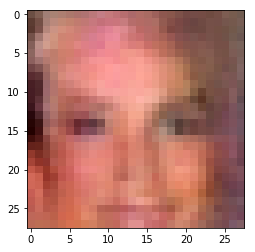

Epoch 6/10... Discriminator Loss: -0.8224... Generator Loss: -15.5497
Epoch 6/10... Discriminator Loss: -0.7107... Generator Loss: -3.4325
Epoch 6/10... Discriminator Loss: -0.8394... Generator Loss: -3.7967
Epoch 6/10... Discriminator Loss: -0.9299... Generator Loss: -6.3823
Epoch 6/10... Discriminator Loss: -0.8205... Generator Loss: 3.9712
Epoch 6/10... Discriminator Loss: -0.2032... Generator Loss: 0.4295
Epoch 6/10... Discriminator Loss: -1.0987... Generator Loss: -13.6090
Epoch 6/10... Discriminator Loss: -0.6198... Generator Loss: 2.5943
Epoch 6/10... Discriminator Loss: -0.7920... Generator Loss: -1.5191
Epoch 6/10... Discriminator Loss: -0.7177... Generator Loss: -1.7960
Epoch 6/10... Discriminator Loss: -0.6501... Generator Loss: -11.6851
Epoch 6/10... Discriminator Loss: -0.3377... Generator Loss: 1.4740
Epoch 6/10... Discriminator Loss: -0.6485... Generator Loss: 5.9337
Epoch 6/10... Discriminator Loss: -0.8570... Generator Loss: -8.5044
Epoch 6/10... Discriminator Loss: -1

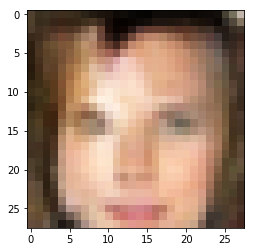

Epoch 7/10... Discriminator Loss: -0.6384... Generator Loss: -7.5285
Epoch 7/10... Discriminator Loss: -0.4690... Generator Loss: 8.8558
Epoch 7/10... Discriminator Loss: -0.7475... Generator Loss: -9.2815
Epoch 7/10... Discriminator Loss: -0.6204... Generator Loss: -3.4947
Epoch 7/10... Discriminator Loss: -0.9078... Generator Loss: -3.1532
Epoch 7/10... Discriminator Loss: -0.6845... Generator Loss: -8.1068
Epoch 7/10... Discriminator Loss: -0.5687... Generator Loss: -1.2636
Epoch 7/10... Discriminator Loss: -0.4864... Generator Loss: 7.8493
Epoch 7/10... Discriminator Loss: -0.7253... Generator Loss: -12.4758
Epoch 7/10... Discriminator Loss: -0.7888... Generator Loss: -6.1243
Epoch 7/10... Discriminator Loss: -0.4117... Generator Loss: -4.0185
Epoch 7/10... Discriminator Loss: -0.4504... Generator Loss: -1.8713
Epoch 7/10... Discriminator Loss: -0.3758... Generator Loss: -13.2353
Epoch 7/10... Discriminator Loss: -0.1900... Generator Loss: -5.1508
Epoch 7/10... Discriminator Loss: 

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 500

epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.